## Innoplexus Online Hiring Hackathon: Sentiment Analysis

#### Import libraries

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# 0-positive, 1-negative, 2-neutral

#### Read data and perform some EDA

In [2]:
traindata = pd.read_csv("train_F3WbcTw.csv")

In [3]:
testdata = pd.read_csv("test_tOlRoBf.csv")

In [24]:
submission = pd.read_csv("sample_submission_i5xnIZD.csv")
submission.drop(["sentiment"],axis = 1,inplace=True)

In [25]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2924 entries, 0 to 2923
Data columns (total 1 columns):
unique_hash    2924 non-null object
dtypes: object(1)
memory usage: 22.9+ KB


In [5]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2924 entries, 0 to 2923
Data columns (total 3 columns):
unique_hash    2924 non-null object
text           2924 non-null object
drug           2924 non-null object
dtypes: object(3)
memory usage: 68.6+ KB


In [6]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5279 entries, 0 to 5278
Data columns (total 4 columns):
unique_hash    5279 non-null object
text           5279 non-null object
drug           5279 non-null object
sentiment      5279 non-null int64
dtypes: int64(1), object(3)
memory usage: 165.0+ KB


In [7]:
traindata.head()

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1


#### Check distribution of target variable

In [8]:
#traindata.groupby(["drug"],as_index=False)["text"].count()
traindata.groupby(["sentiment"],as_index=False)["text"].count()

,sentiment,text
0,0,617
1,1,837
2,2,3825


#### Target variable shows that the data is imbalanced

##### We will handle the problem of imbalanced data later in the script

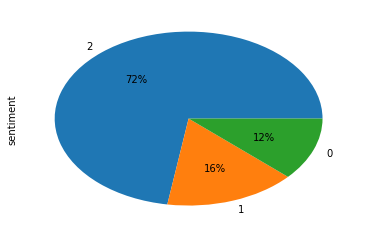

In [9]:
traindata.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%' )

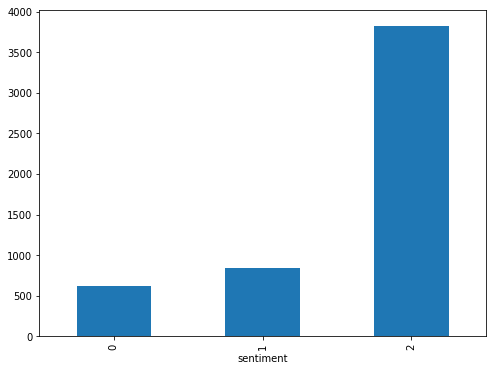

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
traindata.groupby('sentiment').text.count().plot.bar(ylim=0)
plt.show()

### Data preprocessing and cleaning

In [11]:
traindata['word_length'] = [len(x.split(" ")) for x in traindata.text]
max(traindata.word_length)
# traindata.loc[traindata.word_length.idxmax(),'text']

19890

In [12]:
contraction_mapping = {"ain’t": "is not", "aren’t": "are not","can’t": "cannot", 
                   "can’t’ve": "cannot have", "’cause": "because", "could’ve": "could have", 
                   "couldn’t": "could not", "couldn’t’ve": "could not have","didn’t": "did not", 
                   "doesn’t": "does not", "don’t": "do not", "hadn’t": "had not", 
                   "hadn’t’ve": "had not have", "hasn’t": "has not", "haven’t": "have not", 
                   "he’d": "he would", "he’d’ve": "he would have", "he’ll": "he will", 
                   "he’ll’ve": "he will have", "he’s": "he is", "how’d": "how did", 
                   "how’d’y": "how do you", "how’ll": "how will", "how’s": "how is", 
                   "I’d": "I would", "I’d’ve": "I would have", "I’ll": "I will", 
                   "I’ll’ve": "I will have","I’m": "I am", "I’ve": "I have", 
                   "i’d": "i would", "i’d’ve": "i would have", "i’ll": "i will", 
                   "i’ll’ve": "i will have","i’m": "i am", "i’ve": "i have", 
                   "isn’t": "is not", "it’d": "it would", "it’d’ve": "it would have", 
                   "it’ll": "it will", "it’ll’ve": "it will have","it’s": "it is", 
                   "let’s": "let us", "ma’am": "madam", "mayn’t": "may not", 
                   "might’ve": "might have","mightn’t": "might not","mightn’t’ve": "might not have", 
                   "must’ve": "must have", "mustn’t": "must not", "mustn’t’ve": "must not have", 
                   "needn’t": "need not", "needn’t’ve": "need not have","o’clock": "of the clock", 
                   "oughtn’t": "ought not", "oughtn’t’ve": "ought not have", "shan’t": "shall not",
                   "sha’n’t": "shall not", "shan’t’ve": "shall not have", "she’d": "she would", 
                   "she’d’ve": "she would have", "she’ll": "she will", "she’ll’ve": "she will have", 
                   "she’s": "she is", "should’ve": "should have", "shouldn’t": "should not", 
                   "shouldn’t’ve": "should not have", "so’ve": "so have","so’s": "so as", 
                   "this’s": "this is",
                   "that’d": "that would", "that’d’ve": "that would have","that’s": "that is", 
                   "there’d": "there would", "there’d’ve": "there would have","there’s": "there is", 
                       "here’s": "here is",
                   "they’d": "they would", "they’d’ve": "they would have", "they’ll": "they will", 
                   "they’ll’ve": "they will have", "they’re": "they are", "they’ve": "they have", 
                   "to’ve": "to have", "wasn’t": "was not", "we’d": "we would", 
                   "we’d’ve": "we would have", "we’ll": "we will", "we’ll’ve": "we will have", 
                   "we’re": "we are", "we’ve": "we have", "weren’t": "were not", 
                   "what’ll": "what will", "what’ll’ve": "what will have", "what’re": "what are", 
                   "what’s": "what is", "what’ve": "what have", "when’s": "when is", 
                   "when’ve": "when have", "where’d": "where did", "where’s": "where is", 
                   "where’ve": "where have", "who’ll": "who will", "who’ll’ve": "who will have", 
                   "who’s": "who is", "who’ve": "who have", "why’s": "why is", 
                   "why’ve": "why have", "will’ve": "will have", "won’t": "will not", 
                   "won’t’ve": "will not have", "would’ve": "would have", "wouldn’t": "would not", 
                   "wouldn’t’ve": "would not have", "y’all": "you all", "y’all’d": "you all would",
                   "y’all’d’ve": "you all would have","y’all’re": "you all are","y’all’ve": "you all have",
                   "you’d": "you would", "you’d’ve": "you would have", "you’ll": "you will", 
                   "you’ll’ve": "you will have", "you’re": "you are", "you’ve": "you have" } 

In [13]:
import codecs
import unidecode
import re
import spacy
nlp = spacy.load('en')

def spacy_cleaner(text):
    try:
        decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(text)
    apostrophe_handled = re.sub("’", "'", decoded)
    expanded = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in apostrophe_handled.split(" ")])
    parsed = nlp(expanded)
    final_tokens = []
    for t in parsed:
        if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
            pass
        else:
            if t.lemma_ == '-PRON-':
                final_tokens.append(str(t))
            else:
                sc_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
                if len(sc_removed) > 1:
                    final_tokens.append(sc_removed)
    joined = ' '.join(final_tokens)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected

In [14]:
pd.set_option('display.max_colwidth', -1)
traindata.text[:2]


0    Autoimmune diseases tend to come in clusters. As for Gilenya – if you feel good, don’t think about it, it won’t change anything but waste your time and energy. I’m taking Tysabri and feel amazing, no symptoms (other than dodgy color vision, but I’ve had it since always, so, don’t know) and I don’t know if it will last a month, a year, a decade, ive just decided to enjoy the ride, no point in worrying.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [15]:
traindata["lower_text"] = traindata["text"].apply(lambda row : spacy_cleaner(row))

In [16]:
#[spacy_cleaner(t) for t in traindata.text[:2]]

['autoimmune disease tend to come in cluster as for gilenya if you feel good donat think about it it wonat change anything but waste your time and energy iam take tysabri and feel amazing no symptom other than dodgy color vision but iave have it since always so donat know and I donat know if it will last month year decade i have just decide to enjoy the ride no point in worry',
 'I can completely understand why youad want to try it but result report in lecture donat always stand up to the scrutiny of peer review during publication there so much still to do before this be convincing I hope that it do work out I really do and if youare aware of and happy with the risk then thata great I just think itas important to present this in balanced way and to understand why we donat move straight from the first show of promise in an animal study to use drug on human thereas still lot of animal datum to gather and human datum to gather before anyone can tell if itas safe or effective I canat tell 

In [17]:
traindata.head(1)

,unique_hash,text,drug,sentiment,word_length,lower_text
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,"Autoimmune diseases tend to come in clusters. As for Gilenya – if you feel good, don’t think about it, it won’t change anything but waste your time and energy. I’m taking Tysabri and feel amazing, no symptoms (other than dodgy color vision, but I’ve had it since always, so, don’t know) and I don’t know if it will last a month, a year, a decade, ive just decided to enjoy the ride, no point in worrying.",gilenya,2,76,autoimmune disease tend to come in cluster as for gilenya if you feel good donat think about it it wonat change anything but waste your time and energy iam take tysabri and feel amazing no symptom other than dodgy color vision but iave have it since always so donat know and I donat know if it will last month year decade i have just decide to enjoy the ride no point in worry


### Model building

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

stopset = set(stopwords.words("english"))
tvec = TfidfVectorizer(stop_words=None , max_features=100000, ngram_range=(1, 5))
lr = LogisticRegression()

In [91]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

def lr_cv(splits, X, y,Xtest, pipeline, average_method):
    
    accuracy = []
    precision = []
    recall = []
    f1 = []
    lr_fit = pipeline.fit(X, y)
    prediction = lr_fit.predict(Xtest)

    return prediction


#### Over-sampling to get rid of imbalanced data

In [92]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

ROS_pipeline = make_pipeline(tvec, RandomOverSampler(random_state=777),lr)


In [93]:
res = lr_cv(5, traindata.text, traindata.sentiment,testdata.text, ROS_pipeline, 'macro')
print(type(res))

<class 'numpy.ndarray'>


In [94]:
submission["sentiment"] = res

In [95]:
submission.to_csv("submission.csv",index = False)